<a href="https://colab.research.google.com/github/JeremyKrick/traffic-trend-predictor/blob/prachi-dev/Final_Project_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation
from keras.utils import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_uber_15='/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_uber = pd.read_csv(path_uber_15, delimiter = ",")
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [ ]:
df_uber.dtypes

Dispatching_base_num    object
Pickup_date             object
Affiliated_base_num     object
locationID               int64
dtype: object

In [ ]:
df_uber['Pickup_date']= pd.to_datetime(df_uber['Pickup_date'])

In [ ]:
df_uber.dtypes

Dispatching_base_num            object
Pickup_date             datetime64[ns]
Affiliated_base_num             object
locationID                       int64
dtype: object

In [ ]:
df_uber

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90
...,...,...,...,...
14270474,B02765,2015-05-08 15:43:00,B02765,186
14270475,B02765,2015-05-08 15:43:00,B02765,263
14270476,B02765,2015-05-08 15:43:00,B02765,90
14270477,B02765,2015-05-08 15:44:00,B01899,45


In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [ ]:
#use datetime_is_numeric = True to get statistics on the datetime column
desc = df_uber.describe(datetime_is_numeric = True)

#force the printout not to use scientific notation
#desc[desc.columns[:-1]] = desc[desc.columns[:-1]].apply(lambda x: x.apply("{0:.4f}".format))
desc

,Pickup_date,locationID
count,14270479,1.427048e+07
mean,2015-04-07 15:04:13.657453056,1.520574e+02
min,2015-01-01 00:00:05,1.000000e+00
25%,2015-02-21 03:00:16.500000,9.200000e+01
50%,2015-04-10 16:21:00,1.570000e+02
75%,2015-05-23 03:53:00,2.300000e+02
max,2015-06-30 23:59:00,2.650000e+02
std,NaN,7.159620e+01


<Axes: >

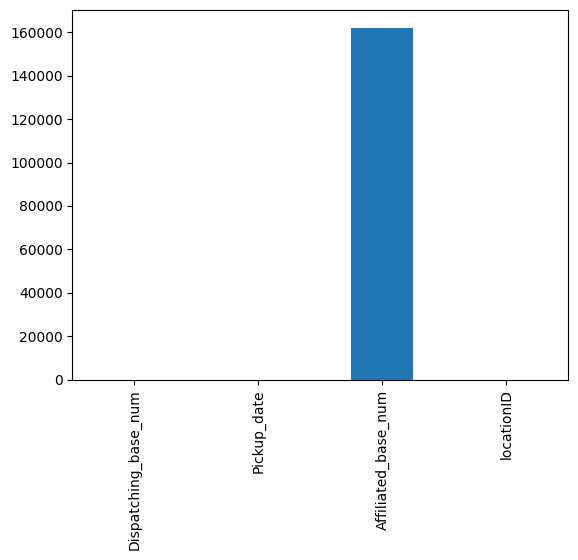

In [ ]:
df_uber.isna().sum().plot.bar()

In [ ]:
df_uber = df_uber.dropna()

<Axes: >

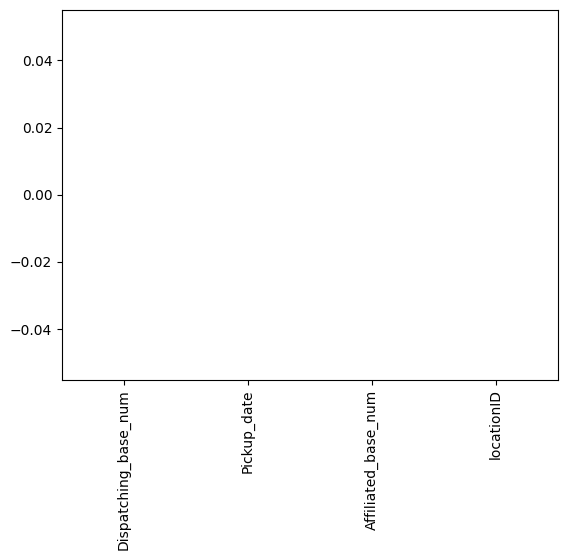

In [ ]:
df_uber.isna().sum().plot.bar()

In [ ]:
df_uber.duplicated().sum()

896732

In [ ]:
df_uber.drop_duplicates(inplace=True)

<ipython-input-14-e22c6e7fe598>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber.drop_duplicates(inplace=True)


In [ ]:
df_uber.duplicated().sum()

0

In [ ]:
df_uber.shape

(13211552, 4)

In [ ]:
df_uber["month"] = df_uber["Pickup_date"].dt.month_name()
df_uber["weekday"] = df_uber["Pickup_date"].dt.day_name()

<ipython-input-17-0fb957b82bb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber["month"] = df_uber["Pickup_date"].dt.month_name()
<ipython-input-17-0fb957b82bb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber["weekday"] = df_uber["Pickup_date"].dt.day_name()


In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,month,weekday
0,B02617,2015-05-17 09:47:00,B02617,141,May,Sunday
1,B02617,2015-05-17 09:47:00,B02617,65,May,Sunday
2,B02617,2015-05-17 09:47:00,B02617,100,May,Sunday
3,B02617,2015-05-17 09:47:00,B02774,80,May,Sunday
4,B02617,2015-05-17 09:47:00,B02617,90,May,Sunday


In [ ]:
df_uber["month"].value_counts()

June        2571771
May         2483980
February    2141306
April       2112705
March       2062639
January     1839151
Name: month, dtype: int64

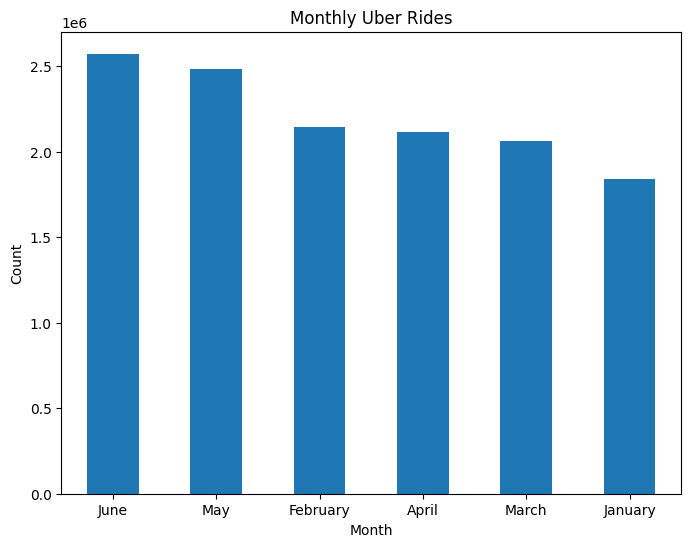

In [ ]:
import matplotlib.pyplot as plt

# Plot data
counts = df_uber["month"].value_counts()
plt.figure(figsize=(8, 6))  # Set the figure size
counts.plot(kind="bar")  # Use skyblue color
plt.xlabel("Month")  # X-axis label
plt.ylabel("Count")  # Y-axis label
plt.title("Monthly Uber Rides")  # Plot title
plt.xticks(rotation=0)  # Set X-axis label rotation

# Show the plot
plt.show()

In [ ]:
pivot = pd.crosstab(index=df_uber["month"], columns=df_uber["weekday"])
pivot

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,315002,238429,324545,273560,372522,250632,338015
February,360136,264693,354962,284432,323955,276956,276172
January,325261,182785,369693,219884,316857,188802,235869
June,371225,375312,399377,334434,357782,405500,328141
March,309631,269931,314785,313865,277026,320634,256767
May,430134,255501,464298,390391,337607,290004,316045


<Figure size 800x600 with 0 Axes>

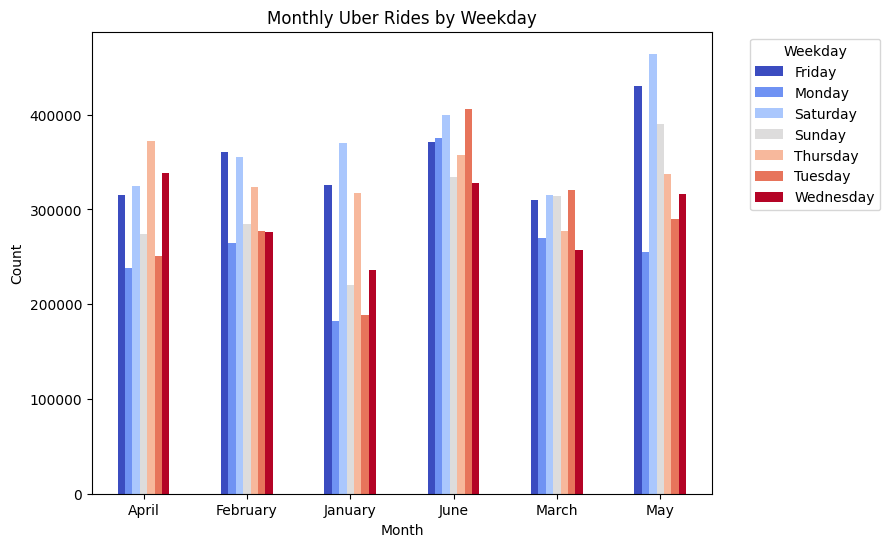

In [ ]:
plt.figure(figsize=(8, 6))  # Set the figure size
pivot.plot(kind="bar", figsize=(8, 6), cmap='coolwarm')  # Use a coolwarm color palette
plt.xlabel("Month")  # X-axis label
plt.ylabel("Count")  # Y-axis label
plt.title("Monthly Uber Rides by Weekday")  # Plot title
plt.xticks(rotation=0)  # Set X-axis label rotation

# Show the plot
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend
plt.show()

In [ ]:
df_uber['hour'] = df_uber['Pickup_date'].dt.hour

<ipython-input-23-eb0e815794cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['hour'] = df_uber['Pickup_date'].dt.hour


In [ ]:
summary = df_uber.groupby(['weekday', 'hour'], as_index=False).size()
summary

,weekday,hour,size
0,Friday,0,78936
1,Friday,1,44064
2,Friday,2,26942
3,Friday,3,18845
4,Friday,4,22798
...,...,...,...
163,Wednesday,19,129724
164,Wednesday,20,122022
165,Wednesday,21,119511
166,Wednesday,22,113909


In [ ]:
sumz=df_uber.groupby(['weekday', 'hour'], as_index=False)

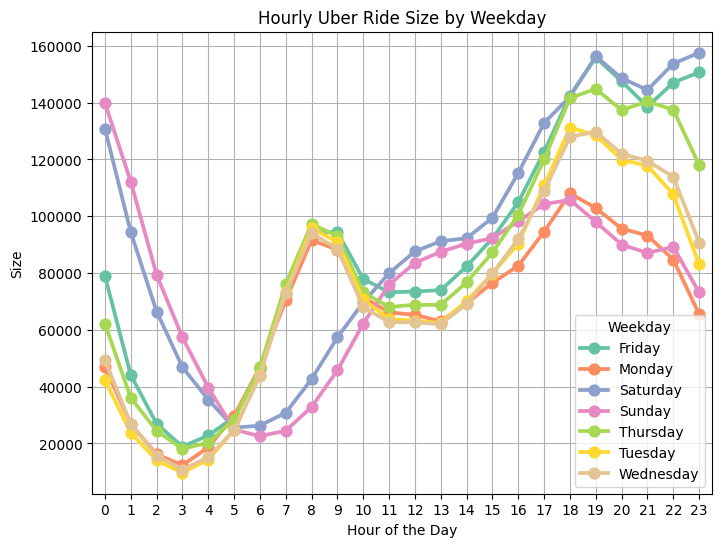

In [ ]:
import seaborn as sns

# Set the figure size
plt.figure(figsize=(8, 6))

# Create the point plot
sns.pointplot(x="hour", y="size", hue="weekday", data=summary, palette="Set2")

# Add labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Size")
plt.title("Hourly Uber Ride Size by Weekday")

# Customize the legend
plt.legend(title="Weekday")

# Show the plot
plt.grid(True)  # Add grid lines
plt.show()

In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,month,weekday,hour
0,B02617,2015-05-17 09:47:00,B02617,141,May,Sunday,9
1,B02617,2015-05-17 09:47:00,B02617,65,May,Sunday,9
2,B02617,2015-05-17 09:47:00,B02617,100,May,Sunday,9
3,B02617,2015-05-17 09:47:00,B02774,80,May,Sunday,9
4,B02617,2015-05-17 09:47:00,B02617,90,May,Sunday,9


In [ ]:
from datetime import datetime
from collections import Counter

#df_uber["MonthNum"] = df_uber["Pickup_date"].dt.month
#df_uber['Month_Day'] = df_uber['Pickup_date'].apply(lambda pickup: datetime.strptime(pickup, '%Y-%m-%d %H:%M:%S').strftime('%m-%d').split('-'))
df_uber['Month_Day'] = df_uber['Pickup_date'].apply(lambda pickup: pickup.strftime('%m-%d').split('-'))

<ipython-input-28-9e383ad4bc7a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['Month_Day'] = df_uber['Pickup_date'].apply(lambda pickup: pickup.strftime('%m-%d').split('-'))


In [ ]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,month,weekday,hour,Month_Day
0,B02617,2015-05-17 09:47:00,B02617,141,May,Sunday,9,"[05, 17]"
1,B02617,2015-05-17 09:47:00,B02617,65,May,Sunday,9,"[05, 17]"
2,B02617,2015-05-17 09:47:00,B02617,100,May,Sunday,9,"[05, 17]"
3,B02617,2015-05-17 09:47:00,B02774,80,May,Sunday,9,"[05, 17]"
4,B02617,2015-05-17 09:47:00,B02617,90,May,Sunday,9,"[05, 17]"


In [ ]:
## Separate month and day
df_uber['Monthumn'] = [month_day [0] for month_day in df_uber['Month_Day']]
df_uber['Day'] = [month_day [1] for month_day in df_uber['Month_Day']]
df_uber.tail(20)

<ipython-input-34-9bad48096917>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['Monthumn'] = [month_day [0] for month_day in df_uber['Month_Day']]
<ipython-input-34-9bad48096917>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uber['Day'] = [month_day [1] for month_day in df_uber['Month_Day']]


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,month,weekday,hour,Month_Day,Monthumn,Day
14270459,B02765,2015-05-08 15:40:00,B02765,186,May,Friday,15,"[05, 08]",05,08
14270460,B02765,2015-05-08 15:41:00,B02764,50,May,Friday,15,"[05, 08]",05,08
14270461,B02765,2015-05-08 15:41:00,B02253,13,May,Friday,15,"[05, 08]",05,08
14270462,B02765,2015-05-08 15:41:00,B02682,192,May,Friday,15,"[05, 08]",05,08
14270463,B02765,2015-05-08 15:41:00,B02345,262,May,Friday,15,"[05, 08]",05,08
14270464,B02765,2015-05-08 15:41:00,B02765,237,May,Friday,15,"[05, 08]",05,08
14270465,B02765,2015-05-08 15:41:00,B02765,233,May,Friday,15,"[05, 08]",05,08
14270466,B02765,2015-05-08 15:41:00,B02765,148,May,Friday,15,"[05, 08]",05,08
14270467,B02765,2015-05-08 15:41:00,B02765,33,May,Friday,15,"[05, 08]",05,08
14270468,B02765,2015-05-08 15:42:00,B02096,232,May,Friday,15,"[05, 08]",05,08


In [ ]:
jan_june_grouped = df_uber.groupby(by = ['Monthumn', 'Day']).size().unstack()
jan_june_grouped

Day,01,02,03,04,05,06,07,08,09,10,...,22,23,24,25,26,27,28,29,30,31
Monthumn,,,,,,,,,,,,,,,,,,,,,
01,54369.0,37789.0,56440.0,39362.0,41045.0,50428.0,59771.0,68634.0,67709.0,75676.0,...,63139.0,69251.0,77850.0,55737.0,41921.0,24422.0,58188.0,66429.0,80565.0,88907.0
02,73855.0,66435.0,67531.0,64330.0,77814.0,82677.0,78290.0,60590.0,59971.0,62595.0,...,63870.0,68709.0,76462.0,72202.0,80585.0,85703.0,85069.0,NaN,NaN,NaN
03,65013.0,53372.0,67373.0,65268.0,69742.0,74966.0,74097.0,56893.0,50523.0,64741.0,...,63765.0,56395.0,59494.0,67387.0,71295.0,77449.0,83857.0,69077.0,58436.0,71292.0
04,64412.0,68539.0,71292.0,65223.0,55686.0,51019.0,62838.0,66425.0,71239.0,75417.0,...,74769.0,83122.0,90534.0,96260.0,81836.0,61267.0,64323.0,70306.0,77116.0,NaN
05,85097.0,95693.0,74748.0,61799.0,70715.0,74536.0,79739.0,83794.0,90412.0,74822.0,...,80253.0,73776.0,64869.0,56636.0,68003.0,80519.0,86293.0,89904.0,95821.0,89357.0
06,85030.0,87861.0,79747.0,85836.0,93082.0,93713.0,82361.0,71611.0,76059.0,80039.0,...,70212.0,84311.0,83254.0,90266.0,91319.0,119208.0,85442.0,69605.0,76246.0,NaN


In [ ]:
## Aggregate results to form a time-series
all_jan_june = [jan_june_grouped.iloc[r,:] for r in range(jan_june_grouped.shape[0])]

In [ ]:
all_jan_june = [trips for month in all_jan_june for trips in month]
len(all_jan_june)

186

In [ ]:
## Remove missing values: here missing values are the days when a month is shorter than 31 days.
remove_inds = list(np.argwhere(np.isnan(all_jan_june) == True).reshape((1,5))[0])
remove_inds

[59, 60, 61, 123, 185]

In [ ]:
all_jan_june_mod = [all_jan_june[i] for i,j in enumerate(all_jan_june) if i not in remove_inds]
len(all_jan_june_mod)

181

In [ ]:
## Convert time-series into data-frame for modeling process
uber_jan_june_final = pd.DataFrame({'Days': range(1,len(all_jan_june_mod)+1), 'Trips': all_jan_june_mod})
uber_jan_june_final.head()

,Days,Trips
0,1,54369.0
1,2,37789.0
2,3,56440.0
3,4,39362.0
4,5,41045.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

## Split into train-test set:
train_jan_june = uber_jan_june_final.iloc[0:167,1:2].values
test_jan_june = uber_jan_june_final.iloc[167:,1:2].values

print ('Training data: ', train_jan_june.shape)
print ('Testing data: ', test_jan_june.shape)

## Feature-scaling:
mms = MinMaxScaler(feature_range = (0,1))
train_jan_june_scaled = mms.fit_transform(train_jan_june)

Training data:  (167, 1)
Testing data:  (14, 1)


In [ ]:
x_train = []
y_train = []

for rides in range(14, 167):
    x_train.append(train_jan_june_scaled[rides-14:rides,0])
    y_train.append(train_jan_june_scaled[rides,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, newshape = (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
## Import required modules:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
np.random.seed(11)
t_start = time.time()

def build_rnn(num_units, input_x, input_y, drpout, epochs, size_of_batch, optimizer, loss):

    regressor = Sequential()

    ## Adding first LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True, input_shape = (input_x.shape[1],1)))
    regressor.add(Dropout(drpout))

    ## Adding second LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding third LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fourth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fifth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = False))
    regressor.add(Dropout(drpout))

    ## Adding o/p layer:
    regressor.add(Dense(units = 1))

    ## Compiling RNN:
    regressor.compile(optimizer = optimizer, loss = loss)

    ## Fitting RNN to training set:
    regressor.fit(x = input_x, y = input_y, epochs = epochs, batch_size = size_of_batch)

    return regressor

regressor = build_rnn(num_units = 40, input_x = x_train, input_y = y_train, drpout = 0.2, epochs = 1000, size_of_batch = 16, optimizer = 'adam', loss = 'mean_squared_error')

print (time.time() - t_start)

Epoch 1/1000
10/10 [==============================] - 11s 33ms/step - loss: 0.2007
Epoch 2/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.0477
Epoch 3/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0357
Epoch 4/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.0296
Epoch 5/1000
10/10 [==============================] - 0s 31ms/step - loss: 0.0287
Epoch 6/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0285
Epoch 7/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.0263
Epoch 8/1000
10/10 [==============================] - 0s 31ms/step - loss: 0.0219
Epoch 9/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0223
Epoch 10/1000
10/10 [==============================] - 0s 33ms/step - loss: 0.0232
Epoch 11/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0243
Epoch 12/1000
10/10 [==============================] - 0s 31ms/step - loss: 0.0249
Epoch 13/100

In [ ]:
adjusted_inputs = uber_jan_june_final[len(uber_jan_june_final) - len(test_jan_june) - 14:]['Trips'].values
adjusted_inputs

array([ 79747.,  85836.,  93082.,  93713.,  82361.,  71611.,  76059.,
        80039.,  91574.,  93842.,  93092.,  83930.,  78854.,  81023.,
        85101.,  90106.,  92982.,  93364.,  82701.,  70212.,  84311.,
        83254.,  90266.,  91319., 119208.,  85442.,  69605.,  76246.])

In [ ]:
adjusted_inputs = adjusted_inputs.reshape(-1,1)
adjusted_inputs = mms.transform(adjusted_inputs)
adjusted_inputs[0:10]

array([[0.65726947],
       [0.72960772],
       [0.81569131],
       [0.82318768],
       [0.68832419],
       [0.56061254],
       [0.61345546],
       [0.66073847],
       [0.79777604],
       [0.82472022]])

In [ ]:
## Create properly structured test set:
x_test = []
for rides in range(14,29):
    x_test.append(adjusted_inputs[rides-14:rides,0])
print(x_test)


[array([0.65726947, 0.72960772, 0.81569131, 0.82318768, 0.68832419,
       0.56061254, 0.61345546, 0.66073847, 0.79777604, 0.82472022,
       0.81581011, 0.70696415, 0.64666049, 0.67242854]), array([0.72960772, 0.81569131, 0.82318768, 0.68832419, 0.56061254,
       0.61345546, 0.66073847, 0.79777604, 0.82472022, 0.81581011,
       0.70696415, 0.64666049, 0.67242854, 0.7208758 ]), array([0.81569131, 0.82318768, 0.68832419, 0.56061254, 0.61345546,
       0.66073847, 0.79777604, 0.82472022, 0.81581011, 0.70696415,
       0.64666049, 0.67242854, 0.7208758 , 0.78033597]), array([0.82318768, 0.68832419, 0.56061254, 0.61345546, 0.66073847,
       0.79777604, 0.82472022, 0.81581011, 0.70696415, 0.64666049,
       0.67242854, 0.7208758 , 0.78033597, 0.81450329]), array([0.68832419, 0.56061254, 0.61345546, 0.66073847, 0.79777604,
       0.82472022, 0.81581011, 0.70696415, 0.64666049, 0.67242854,
       0.7208758 , 0.78033597, 0.81450329, 0.81904151]), array([0.56061254, 0.61345546, 0.66073847, 0

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape = (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(15, 14, 1)

In [ ]:
## Make prediction for test set and bring values back to original scale
pred = regressor.predict(x_test)
pred = mms.inverse_transform(pred)

## Check RMSE on test-set
residuals = pred[0:-1] - test_jan_june
rmse = np.sqrt(np.mean(residuals**2))
rmse

1/1 [==============================] - 3s 3s/step


10727.59858104872

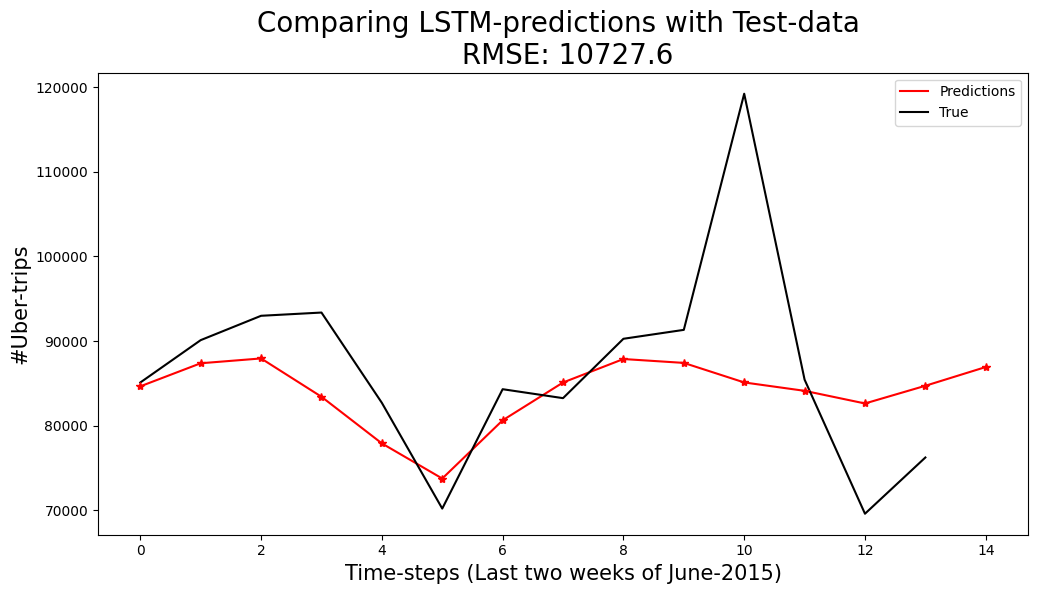

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))

e = [i*0.05 for i in pred]
ax.plot(pred, color = 'red', label = 'Predictions')
ax.errorbar(x = range(15), y = pred, fmt = '*', color = 'r')
ax.plot(test_jan_june, color = 'black', label = 'True')

ax.set_xlabel('Time-steps (Last two weeks of June-2015)', fontsize = 15)
ax.set_ylabel('#Uber-trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with Test-data \n RMSE: {}'.format(np.round(rmse,2)), fontsize = 20)

ax.legend()
plt.show()

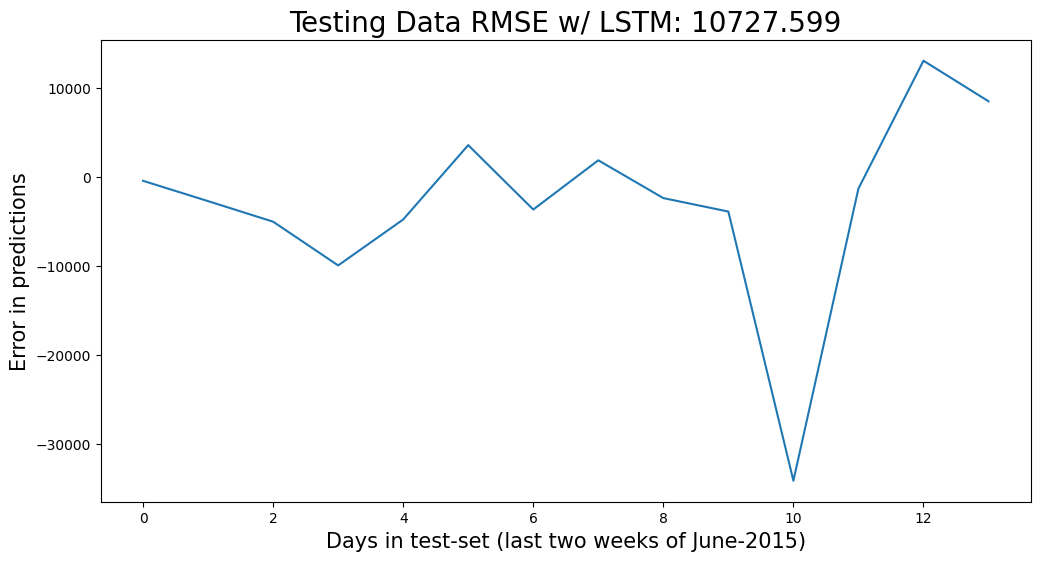

In [ ]:
fig ,ax = plt.subplots(figsize = (12,6))
ax.plot(residuals)

ax.set_xlabel('Days in test-set (last two weeks of June-2015)', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('Testing Data RMSE w/ LSTM: {}'.format(round(rmse, 3)), fontsize = 20)
plt.show()

5/5 [==============================] - 0s 32ms/step


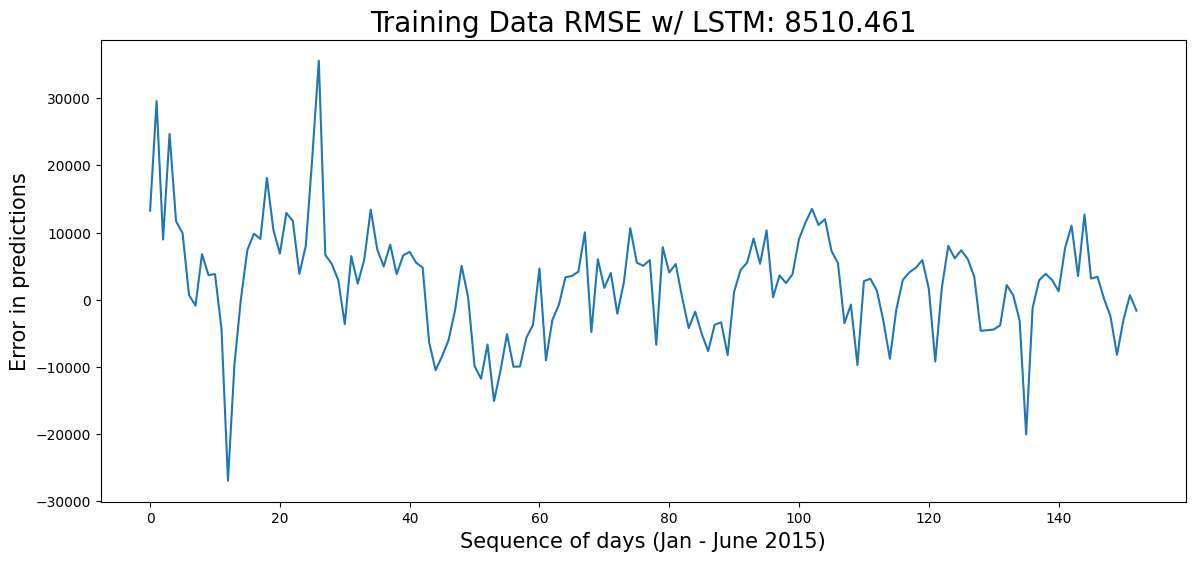

In [ ]:
pred_train = regressor.predict(x_train)
pred_train = mms.inverse_transform(pred_train)

residuals_train = pred_train - train_jan_june[0:-14]
rmse_train = np.sqrt(np.mean(residuals_train**2))

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(residuals_train)
ax.set_xlabel('Sequence of days (Jan - June 2015)', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('Training Data RMSE w/ LSTM: {}'.format(round(rmse_train,3)), fontsize = 20)
plt.show()

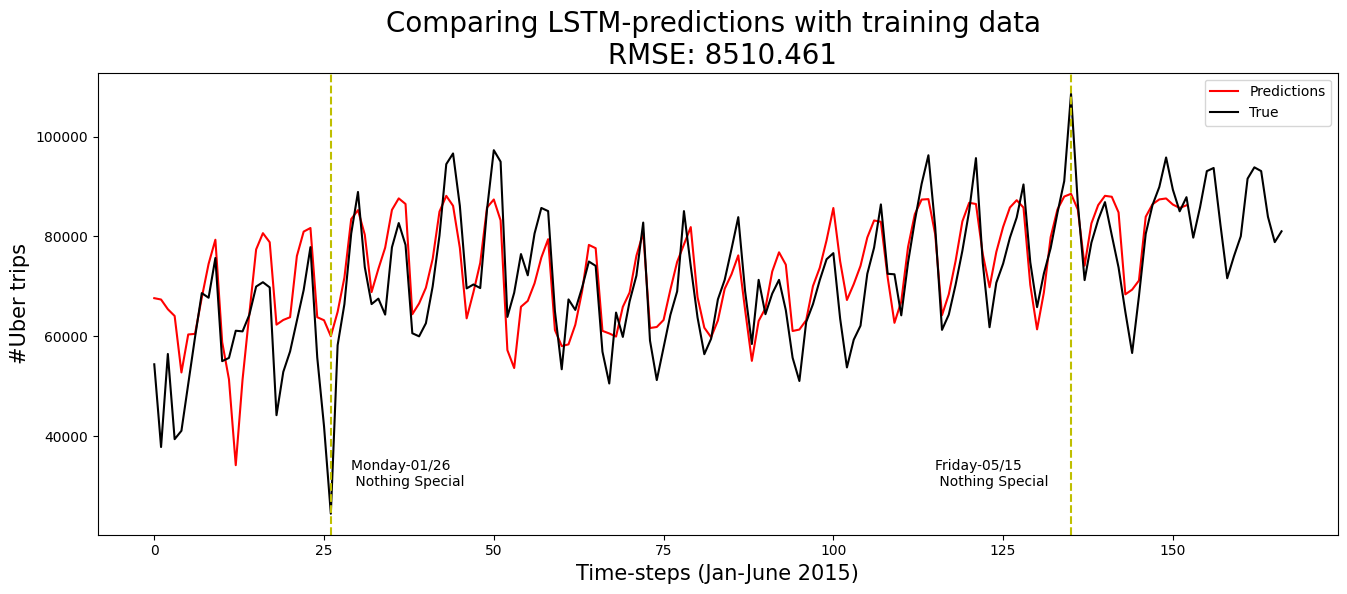

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

ax.plot(pred_train, color = 'red', label = 'Predictions')
ax.plot(train_jan_june, color = 'black', label = 'True')

ax.axvline(x = 26, color = 'y', linestyle = 'dashed')
ax.text(x = 29, y = 30000, s = 'Monday-01/26 \n Nothing Special')

ax.axvline(x = 135, color = 'y', linestyle = 'dashed')
ax.text(x = 115, y = 30000, s = 'Friday-05/15 \n Nothing Special')

ax.set_xlabel('Time-steps (Jan-June 2015)', fontsize = 15)
ax.set_ylabel('#Uber trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with training data \n RMSE: {}'.format(round(rmse_train,3)), fontsize = 20)

ax.legend()
plt.show()

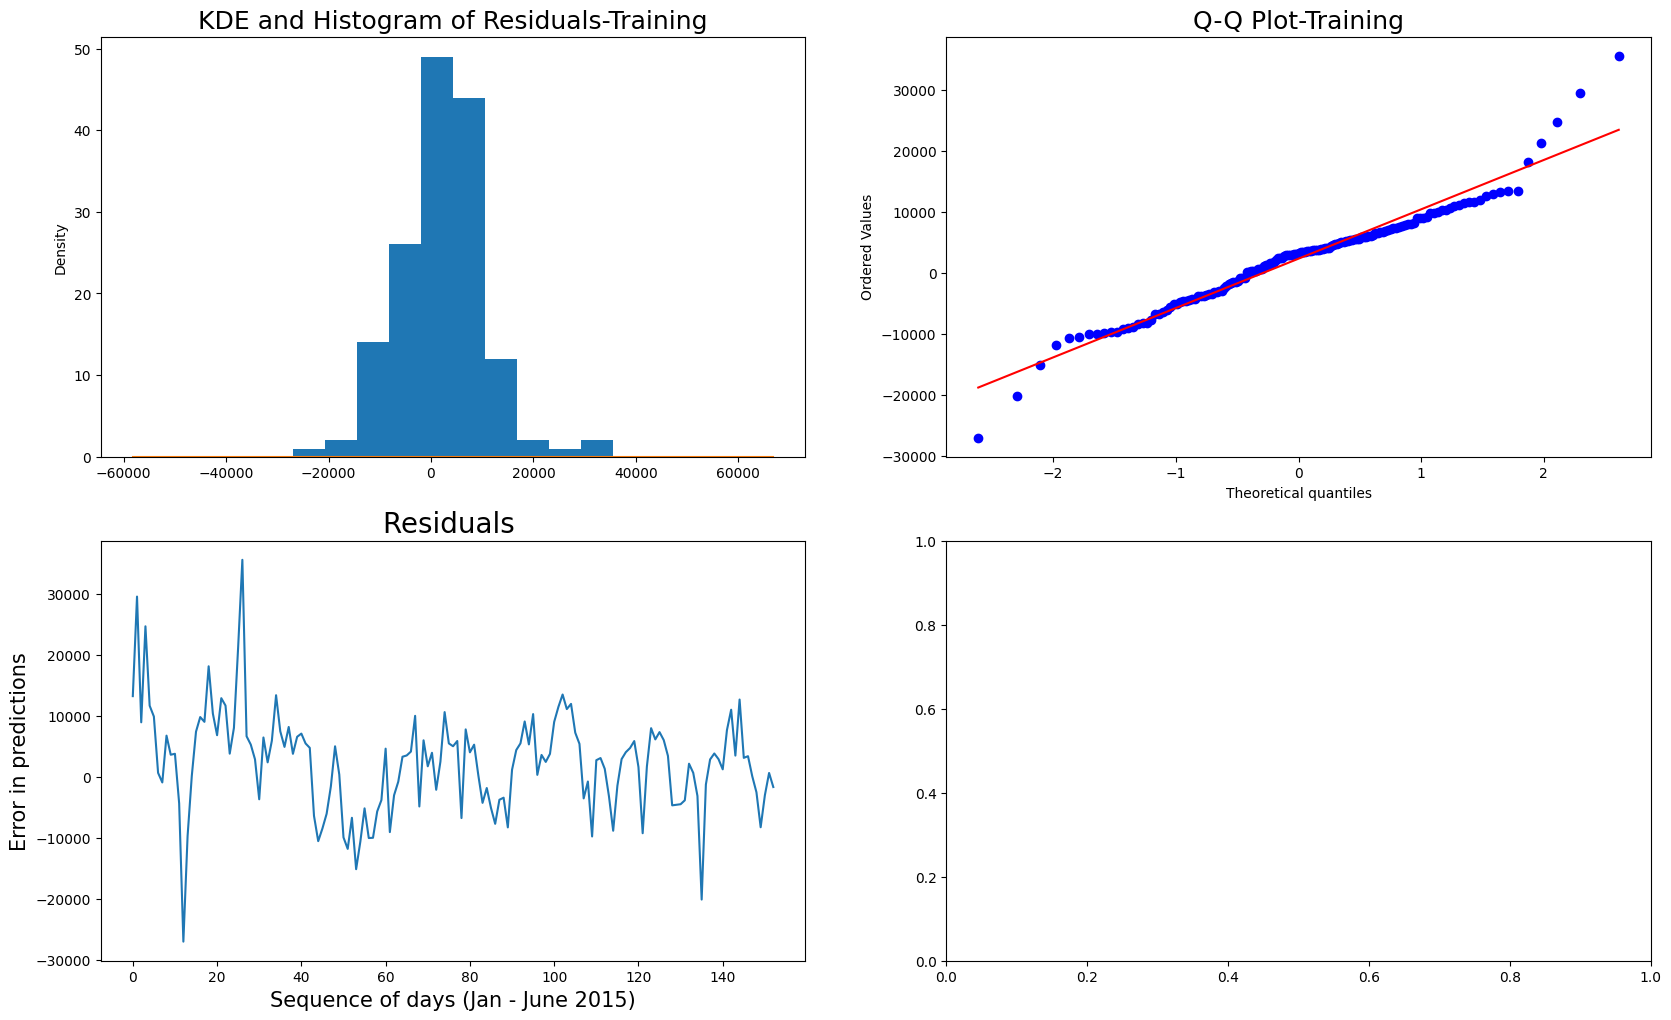

In [ ]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (20,12))
g = gridspec.GridSpec(2,2)

ax1 = plt.subplot(g[0,0])
ax1.hist(residuals_train)
pd.DataFrame(residuals_train).plot(kind = 'kde', ax = ax1, label = 'KDE')
ax1.set_title('KDE and Histogram of Residuals-Training', fontsize = 18)
ax1.legend_.remove()

ax2 = plt.subplot(g[0,1])
import scipy.stats as ss
ss.probplot(residuals_train[:,0].tolist(), plot = ax2)
ax2.set_title('Q-Q Plot-Training', fontsize = 18)

ax3 = plt.subplot(g[1,0])
ax3.plot(residuals_train)
ax3.set_xlabel('Sequence of days (Jan - June 2015)', fontsize = 15)
ax3.set_ylabel('Error in predictions', fontsize = 15)
ax3.set_title('Residuals ', fontsize = 20)

ax4 = plt.subplot(g[1,1])
#acp(residuals_train, ax = ax4)

plt.show()